<a href="https://colab.research.google.com/github/iskra3138/GluonTS/blob/master/2_Quick_Start_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref. https://gluon-ts.mxnet.io/examples/basic_forecasting_tutorial/tutorial.html

# 환경 구현

Colab에서 어떤 GPU가 할당되었는 지 확인

In [1]:
!nvidia-smi

Tue Apr 21 04:54:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

MXNET 설치 
- GluonTS는 Amazon이 2019년 공개한 Tool로서 MXNET을 backbone으로 사용
  - https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/

- 어떤 버전의 MXNET을 설치해야 하는 지는 아래 링크 참고
  - https://mxnet.apache.org/get_started/?platform=linux&language=python&processor=gpu&environ=pip&

In [2]:
# nvidia-smi로 CUDA Version 확인하고 해당되는 MXNET 설치
!pip install mxnet-cu101

     |████████████████████████████████| 710.5MB 24kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


colab에서 GluoTS Tutorial을 이용할 때 최신 pydantic package가 설치되면 아래 에러가 나오므로 1.4로 설치해줌
- TypeError: create_model() takes exactly 1 positional argument (0 given)


In [0]:
!pip install pydantic==1.4

GluonTS를 설치함
- 설치가 완료되면 Restart Runtime Box를 클릭하여 Runtime을 재시작하고 Tutorial을 시작

In [0]:
!pip install gluonts

# Quick Start Tutorial

The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomaly detection.

The toolkit is not intended as a forecasting solution for businesses or end users but it rather targets scientists and engineers who want to tweak algorithms or build and experiment with their own models.  

GluonTS contains:

* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* A number of pre-built models
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [0]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### GluonTS datasets

GluonTS comes with a number of publicly available datasets.

In [0]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

In [4]:
dataset = get_dataset("m4_hourly", regenerate=True)

INFO:root:downloading and processing m4_hourly


saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


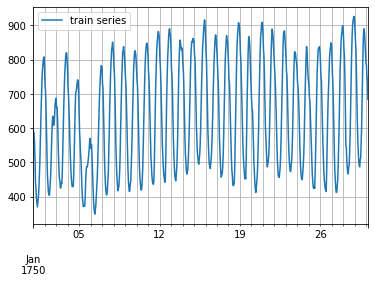

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

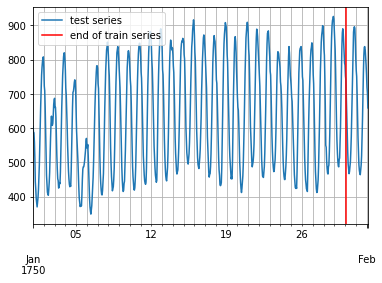

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Timestamp` (possibly different for each time series):

In [0]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [0]:
from gluonts.dataset.common import ListDataset

In [0]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start} 
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start} 
                       for x in custom_dataset],
                      freq=freq)

## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [11]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

INFO:root:Using GPU


In [0]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [13]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 48513


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 117.07it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[0] Elapsed time 0.856 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.495206
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 125.33it/s, avg_epoch_loss=4.73]
INFO:root:Epoch[1] Elapsed time 0.801 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.732299
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 118.58it/s, avg_epoch_loss=4.71]
INFO:root:Epoch[2] Elapsed time 0.846 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.712132
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 123.94it/s, avg_epoch_loss=4.71]
INFO:root:Epoch[3] Elapsed time 0.814 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.712250
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 123.93it/s, avg_epoch_loss=4.73]
INFO:root:Epoch[4] Elapsed time 0.812 seconds
INFO:ro

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [0]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [0]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [0]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [0]:
# first entry of the time series list
ts_entry = tss[0]

In [18]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [0]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [20]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [0]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [22]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [23]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [655.8004  595.3795  524.8817  501.8864  485.10486 471.24774 505.8733
 485.41318 536.2931  638.1106  653.57806 682.96814 789.8887  802.6978
 848.5027  892.0915  897.211   874.9288  903.60156 898.71466 812.50073
 822.2512  802.8217  710.7657  622.0331  538.49396 532.81995 507.06195
 475.94266 485.8225  509.87048 527.7546  559.4346  612.8638  641.4186
 737.98083 788.4026  771.8682  874.54156 860.83264 855.7863  882.87463
 928.92664 891.096   850.83203 793.5296  727.6358  786.2034 ]
0.5-quantile (median) of the future window:
 [669.31213 589.46436 539.4034  507.06595 482.55493 474.0014  515.39105
 492.2898  535.94403 621.2151  655.6507  680.71716 816.27765 817.6303
 847.1178  896.5409  910.65607 880.862   907.84296 896.50684 835.1308
 816.3674  793.8408  699.7311  624.82043 543.80206 540.4126  510.0077
 485.02222 489.5314  504.6732  522.4373  554.91254 608.14526 631.3496
 726.9199  770.8872  773.53253 871.1392  889.02716 832.6614  892.80066
 929.04736 865.83295

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [0]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

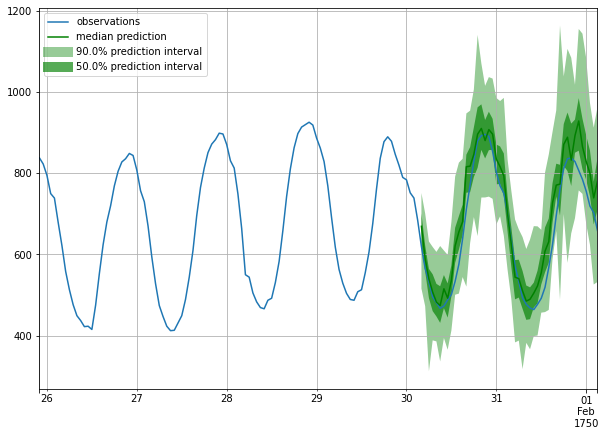

In [25]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [0]:
from gluonts.evaluation import Evaluator

In [27]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:02<00:00, 187.98it/s]


Aggregate metrics aggregate both across time-steps and across time series.

In [28]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 9923002.001817122,
    "abs_error": 10052422.920700073,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 3.280787238502684,
    "sMAPE": 0.188115624913569,
    "MSIS": 33.99115620291589,
    "QuantileLoss[0.1]": 3752435.2633779524,
    "Coverage[0.1]": 0.11714975845410623,
    "QuantileLoss[0.5]": 10052422.856055737,
    "Coverage[0.5]": 0.6009460547504023,
    "QuantileLoss[0.9]": 6804077.710603332,
    "Coverage[0.9]": 0.877667069243156,
    "RMSE": 3150.079681820306,
    "NRMSE": 0.43005545584172244,
    "ND": 0.0690608779988239,
    "wQuantileLoss[0.1]": 0.025779503704424514,
    "wQuantileLoss[0.5]": 0.0690608775547126,
    "wQuantileLoss[0.9]": 0.046744509694163286,
    "mean_wQuantileLoss": 0.04719496365110013,
    "MAE_Coverage": 0.046809581320450856
}


Individual metrics are aggregated only across time-steps.

In [29]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,3155.145833,2073.397217,31644.0,659.250000,42.371302,1.019458,0.063568,5.491491,709.749518,0.020833,2073.397308,0.895833,1444.280396,1.000000
1,NaN,199367.291667,20307.580078,124149.0,2586.437500,165.107988,2.562411,0.155752,17.157588,4952.655298,0.458333,20307.579956,1.000000,8416.701367,1.000000
2,NaN,29000.760417,5976.101074,65030.0,1354.791667,78.889053,1.578192,0.086959,14.028185,2946.556104,0.000000,5976.101013,0.229167,2627.253223,0.791667
3,NaN,166730.500000,15336.392578,235783.0,4912.145833,258.982249,1.233707,0.065361,6.703957,7312.159521,0.041667,15336.393066,0.520833,7458.765918,1.000000
4,NaN,106049.010417,12096.396484,131088.0,2731.000000,200.494083,1.256936,0.085724,6.210466,3284.816699,0.083333,12096.395874,0.812500,6955.907812,1.000000


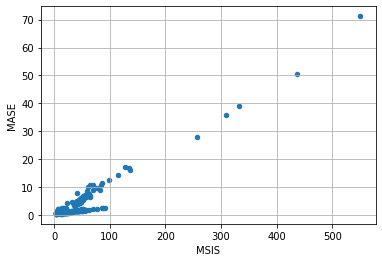

In [30]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## Create your own forecast model

For creating your own forecast model you need to:

- Define the training and prediction network
- Define a new estimator that specifies any data processing and uses the networks

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:

- Both should have a `hybrid_forward` method that defines what should happen when the network is called    
- The training network's `hybrid_forward` should return a **loss** based on the prediction and the true values
- The prediction network's `hybrid_forward` should return the predictions 

For example, we can create a simple training network that defines a neural network which takes as an input the past values of the time series and outputs a future predicted window of length `prediction_length`. It uses the L1 loss in the `hybrid_forward` method to evaluate the error among the predictions and the true values of the time series. The corresponding prediction network should be identical to the training network in terms of architecture (we achieve this by inheriting the training network class), and its `hybrid_forward` method outputs directly the predictions.

Note that this simple model does only point forecasts by construction, i.e., we train it to outputs directly the future values of the time series and not any probabilistic view of the future (to achieve this we should train a network to learn a probability distribution and then sample from it to create sample paths).

In [0]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

Now, we need to construct the estimator which should also follow some rules:

- It should include a `create_transformation` method that defines all the possible feature transformations and how the data is split during training
- It should include a `create_training_network` method that returns the training network configured with any necessary hyperparameters
- It should include a `create_predictor` method that creates the prediction network, and returns a `Predictor` object

A `Predictor` defines the `predict` method of a given predictor. Roughly, this method takes the test dataset, it passes it through the prediction network and yields the predictions. You can think of the `Predictor` object as a wrapper of the prediction network that defines its `predict` method.

Earlier, we used the `make_evaluation_predictions` to evaluate our predictor. Internally, the `make_evaluation_predictions` function invokes the `predict` method of the predictor to get the forecasts.

In [0]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from gluonts.dataset.field_names import FieldName
from mxnet.gluon import HybridBlock

In [33]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq


    def create_transformation(self):
        # Feature transformation that the model uses for input.
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

INFO:root:Using GPU


Now, we can repeat the same pipeline as in the case we had a pre-built model: train the predictor, create the forecasts and evaluate the results.

In [0]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

In [35]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MyTrainNetwork: 7648


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 146.96it/s, avg_epoch_loss=2.77e+3]
INFO:root:Epoch[0] Elapsed time 0.686 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2767.610833
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 148.07it/s, avg_epoch_loss=1.07e+3]
INFO:root:Epoch[1] Elapsed time 0.678 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1073.255271
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 144.86it/s, avg_epoch_loss=979]
INFO:root:Epoch[2] Elapsed time 0.694 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=978.698582
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 142.68it/s, avg_epoch_loss=780]
INFO:root:Epoch[3] Elapsed time 0.704 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=779.538260
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 142.00it/s, avg_epoch_loss=798]
INFO:root:Epoch[4] Elapsed time 0.707 s

In [0]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
    num_samples=100
)

In [0]:
forecasts = list(forecast_it)
tss = list(ts_it)

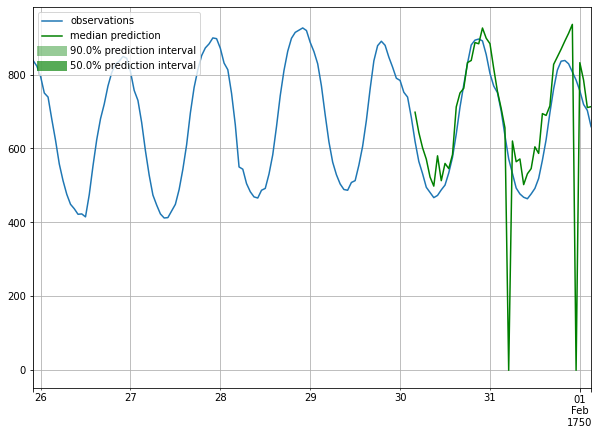

In [39]:
plot_prob_forecasts(tss[0], forecasts[0])

Observe that we cannot actually see any prediction intervals in the predictions. This is expected since the model that we defined does not do probabilistic forecasting but it just gives point estimates. By requiring 100 sample paths (defined in `make_evaluation_predictions`) in such a network, we get 100 times the same output.

In [40]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:02<00:00, 190.48it/s]


In [41]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 91474540.92832339,
    "abs_error": 16743819.362300873,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 6.719143492332734,
    "sMAPE": 0.3008992216472931,
    "MSIS": 268.7657393830555,
    "QuantileLoss[0.1]": 17590344.83395681,
    "Coverage[0.1]": 0.6072866344605473,
    "QuantileLoss[0.5]": 16743819.537101269,
    "Coverage[0.5]": 0.6072866344605473,
    "QuantileLoss[0.9]": 15897294.240245724,
    "Coverage[0.9]": 0.6072866344605473,
    "RMSE": 9564.232375278394,
    "NRMSE": 1.305728974941257,
    "ND": 0.11503125916370377,
    "wQuantileLoss[0.1]": 0.12084695084143277,
    "wQuantileLoss[0.5]": 0.11503126036459523,
    "wQuantileLoss[0.9]": 0.10921556988775767,
    "mean_wQuantileLoss": 0.11503126036459521,
    "MAE_Coverage": 0.30242887815351577
}


In [42]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,2.338038e+04,3783.302002,31644.0,659.250000,42.371302,1.860193,0.162567,74.407720,4525.895789,0.875000,3783.302185,0.875000,3040.708582,0.875000
1,NaN,5.956528e+05,26836.882812,124149.0,2586.437500,165.107988,3.386279,0.251146,135.451155,39098.391260,0.958333,26836.884033,0.958333,14575.376807,0.958333
2,NaN,1.589772e+05,11218.663086,65030.0,1354.791667,78.889053,2.962669,0.203668,118.506768,4433.137378,0.312500,11218.663452,0.312500,18004.189526,0.312500
3,NaN,1.577465e+06,27328.699219,235783.0,4912.145833,258.982249,2.198405,0.150529,87.936207,18998.279199,0.395833,27328.698730,0.395833,35659.118262,0.395833
4,NaN,6.167346e+05,22396.359375,131088.0,2731.000000,200.494083,2.327205,0.206504,93.088198,22811.661377,0.625000,22396.359619,0.625000,21981.057861,0.625000
5,NaN,1.430899e+06,28374.111328,303379.0,6320.395833,212.875740,2.776866,0.141427,111.074629,29915.784668,0.750000,28374.110840,0.750000,26832.437012,0.750000
6,NaN,1.045298e+08,193947.609375,1985325.0,41360.937500,1947.687870,2.074550,0.133180,82.981982,113893.219141,0.458333,193947.595703,0.458333,274001.972266,0.458333
7,NaN,5.076853e+07,150424.437500,1540706.0,32098.041667,1624.044379,1.929653,0.139257,77.186122,103851.577734,0.520833,150424.435547,0.520833,196997.293359,0.520833
8,NaN,6.711389e+07,214544.625000,1640860.0,34184.583333,1850.988166,2.414753,0.167868,96.590119,270047.983984,0.937500,214544.607422,0.937500,159041.230859,0.937500
9,NaN,1.026954e+04,1904.801514,21408.0,446.000000,10.526627,3.769808,0.127385,150.792329,1084.934570,0.520833,1904.801514,0.520833,2724.668457,0.520833


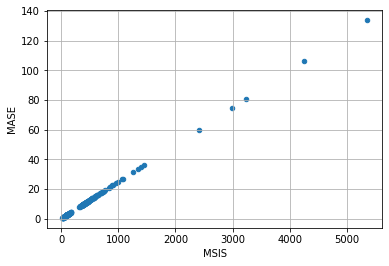

In [43]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()